# EfficientNet

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
LABELS_CSV_PATH = '/kaggle/input/ffpp-fix/labels.csv'
NEW_BASE_PATH = "/kaggle/input/ffpp-fix/frames_cropped_new/"
IMG_SIZE = 224 
BATCH_SIZE = 32 
LEARNING_RATE = 1e-4 
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
try:
    labels_df = pd.read_csv(LABELS_CSV_PATH)
    labels_df['filepath'] = labels_df['filepath'].apply(lambda x: os.path.join(NEW_BASE_PATH, os.path.basename(x)))
    print(f"Successfully loaded labels.csv. Number of entries: {len(labels_df)}")
except FileNotFoundError:
    print(f"Error: {LABELS_CSV_PATH} not found. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading or processing labels_df: {e}")
    exit()

try:
    if labels_df['label'].dtype != 'int':
        labels_df['label'] = labels_df['label'].astype(int)
    NUM_CLASSES = labels_df['label'].nunique()
    if NUM_CLASSES == 0:
        raise ValueError("No unique classes found in 'label' column.")
    print(f"Number of unique classes: {NUM_CLASSES}")
except Exception as e:
    print(f"Error determining number of classes or processing 'label' column: {e}")
    print("Please ensure your 'label' column in labels.csv contains integer class indices (e.g., 0, 1, 2...).")
    exit()

Successfully loaded labels.csv. Number of entries: 6974
Number of unique classes: 2


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label = int(self.dataframe.iloc[idx]['label'])

        if not os.path.exists(img_path):
            print(f"Warning: File not found (idx {idx}): {img_path}. Returning None.")
            return None, None

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image (idx {idx}) {img_path} (cv2.imread failed). Skipping.")
                return None, None
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image (idx {idx}) {img_path} with cv2: {e}")
            return None, None

        if self.transform:
            try:
                image = self.transform(image) 
            except Exception as e:
                print(f"Error applying transform to image (idx {idx}) {img_path}: {e}")
                return None, None
        
        if image is None: 
             print(f"Warning: Image became None unexpectedly before tensor conversion (idx {idx}) {img_path}. Skipping.")
             return None, None

        return image, torch.tensor(label, dtype=torch.long)

In [5]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=0.1,
        fill=0
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=preprocess.mean,
        std=preprocess.std
    )
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=preprocess.mean, std=preprocess.std)
])

In [6]:
valid_indices = [i for i, row in labels_df.iterrows() if os.path.exists(row['filepath'])]
if len(valid_indices) < len(labels_df):
    print(f"Warning: {len(labels_df) - len(valid_indices)} image paths were invalid and removed.")
    labels_df_filtered = labels_df.iloc[valid_indices].reset_index(drop=True)
else:
    labels_df_filtered = labels_df

if len(labels_df_filtered) == 0:
    print("No valid image paths found after filtering. Exiting.")
    exit()

stratify_column = labels_df_filtered['label']

if NUM_CLASSES <= 1: # Stratification requires at least 2 classes
    train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42)
    print("Warning: Number of classes is 1 or less, stratification is disabled.")
else:
    try:
        train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42, stratify=stratify_column)
    except ValueError as e:
        print(f"Error during train_test_split stratification: {e}")
        print("This can happen if a class has too few samples. Falling back to non-stratified split.")
        train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42)


print(f"Training samples: {len(train_df)}, Test samples: {len(test_df)}")

Training samples: 5579, Test samples: 1395


In [7]:
def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch: 
        return torch.Tensor(), torch.Tensor() 
    return torch.utils.data.dataloader.default_collate(batch)

train_dataset = CustomImageDataset(train_df, transform=train_transforms)
test_dataset = CustomImageDataset(test_df, transform=test_transforms)

def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None and x[1] is not None, batch))
    if not batch:
        return torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

train_dataset = CustomImageDataset(train_df, transform=train_transforms)
test_dataset = CustomImageDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn_skip_none)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn_skip_none)

In [8]:
model = efficientnet_b0(weights=weights) 

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(num_ftrs, NUM_CLASSES)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s] 


Starting training on cuda for 50 epochs...


Epoch 1/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 1/50 - Train Loss: 0.4078, Train Acc: 84.35%


Epoch 1/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 1/50 - Val Loss: 0.3775, Val Acc: 85.95%


Epoch 2/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 2/50 - Train Loss: 0.3207, Train Acc: 86.79%


Epoch 2/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 2/50 - Val Loss: 0.3351, Val Acc: 87.38%


Epoch 3/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 3/50 - Train Loss: 0.2900, Train Acc: 88.12%


Epoch 3/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 3/50 - Val Loss: 0.2943, Val Acc: 89.18%


Epoch 4/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 4/50 - Train Loss: 0.2473, Train Acc: 89.89%


Epoch 4/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 4/50 - Val Loss: 0.2893, Val Acc: 89.53%


Epoch 5/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 5/50 - Train Loss: 0.2145, Train Acc: 90.66%


Epoch 5/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 5/50 - Val Loss: 0.3934, Val Acc: 88.03%


Epoch 6/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 6/50 - Train Loss: 0.1929, Train Acc: 91.83%


Epoch 6/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 6/50 - Val Loss: 0.3158, Val Acc: 89.53%


Epoch 7/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 7/50 - Train Loss: 0.1862, Train Acc: 92.17%


Epoch 7/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 7/50 - Val Loss: 0.3293, Val Acc: 89.25%


Epoch 8/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 8/50 - Train Loss: 0.1624, Train Acc: 93.58%


Epoch 8/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 8/50 - Val Loss: 0.2937, Val Acc: 89.10%


Epoch 9/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 9/50 - Train Loss: 0.1448, Train Acc: 94.01%


Epoch 9/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 9/50 - Val Loss: 0.3248, Val Acc: 89.39%


Epoch 10/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 10/50 - Train Loss: 0.1334, Train Acc: 94.62%


Epoch 10/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 10/50 - Val Loss: 0.4289, Val Acc: 89.03%


Epoch 11/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 11/50 - Train Loss: 0.1271, Train Acc: 94.77%


Epoch 11/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 11/50 - Val Loss: 0.3983, Val Acc: 89.10%


Epoch 12/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 12/50 - Train Loss: 0.1116, Train Acc: 95.72%


Epoch 12/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 12/50 - Val Loss: 0.4262, Val Acc: 89.25%


Epoch 13/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 13/50 - Train Loss: 0.1124, Train Acc: 95.50%


Epoch 13/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 13/50 - Val Loss: 0.3958, Val Acc: 89.25%


Epoch 14/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 14/50 - Train Loss: 0.0947, Train Acc: 96.20%


Epoch 14/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 14/50 - Val Loss: 0.4817, Val Acc: 88.75%


Epoch 15/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 15/50 - Train Loss: 0.0930, Train Acc: 96.36%


Epoch 15/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 15/50 - Val Loss: 0.3407, Val Acc: 89.53%


Epoch 16/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 16/50 - Train Loss: 0.0950, Train Acc: 96.15%


Epoch 16/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 16/50 - Val Loss: 0.3697, Val Acc: 90.61%


Epoch 17/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 17/50 - Train Loss: 0.0878, Train Acc: 96.45%


Epoch 17/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 17/50 - Val Loss: 0.4173, Val Acc: 89.96%


Epoch 18/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 18/50 - Train Loss: 0.0749, Train Acc: 97.22%


Epoch 18/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 18/50 - Val Loss: 0.4277, Val Acc: 89.53%


Epoch 19/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 19/50 - Train Loss: 0.0785, Train Acc: 97.06%


Epoch 19/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 19/50 - Val Loss: 0.4881, Val Acc: 88.60%


Epoch 20/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 20/50 - Train Loss: 0.0742, Train Acc: 96.90%


Epoch 20/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 20/50 - Val Loss: 0.4433, Val Acc: 89.68%


Epoch 21/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 21/50 - Train Loss: 0.0598, Train Acc: 97.58%


Epoch 21/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 21/50 - Val Loss: 0.4938, Val Acc: 89.46%


Epoch 22/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 22/50 - Train Loss: 0.0652, Train Acc: 97.58%


Epoch 22/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 22/50 - Val Loss: 0.5724, Val Acc: 88.67%


Epoch 23/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 23/50 - Train Loss: 0.0740, Train Acc: 97.22%


Epoch 23/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 23/50 - Val Loss: 0.4012, Val Acc: 89.89%


Epoch 24/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 24/50 - Train Loss: 0.0556, Train Acc: 97.92%


Epoch 24/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 24/50 - Val Loss: 0.5113, Val Acc: 88.67%


Epoch 25/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 25/50 - Train Loss: 0.0577, Train Acc: 97.78%


Epoch 25/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 25/50 - Val Loss: 0.4368, Val Acc: 90.04%


Epoch 26/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 26/50 - Train Loss: 0.0604, Train Acc: 97.60%


Epoch 26/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 26/50 - Val Loss: 0.4629, Val Acc: 89.46%


Epoch 27/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 27/50 - Train Loss: 0.0552, Train Acc: 97.60%


Epoch 27/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 27/50 - Val Loss: 0.5259, Val Acc: 88.96%


Epoch 28/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 28/50 - Train Loss: 0.0495, Train Acc: 98.21%


Epoch 28/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 28/50 - Val Loss: 0.5355, Val Acc: 89.03%


Epoch 29/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 29/50 - Train Loss: 0.0491, Train Acc: 98.08%


Epoch 29/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 29/50 - Val Loss: 0.4236, Val Acc: 89.82%


Epoch 30/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 30/50 - Train Loss: 0.0472, Train Acc: 98.39%


Epoch 30/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 30/50 - Val Loss: 0.4535, Val Acc: 89.96%


Epoch 31/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 31/50 - Train Loss: 0.0545, Train Acc: 97.71%


Epoch 31/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 31/50 - Val Loss: 0.4742, Val Acc: 89.39%


Epoch 32/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 32/50 - Train Loss: 0.0537, Train Acc: 98.06%


Epoch 32/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 32/50 - Val Loss: 0.4824, Val Acc: 88.75%


Epoch 33/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 33/50 - Train Loss: 0.0511, Train Acc: 98.06%


Epoch 33/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 33/50 - Val Loss: 0.5213, Val Acc: 89.89%


Epoch 34/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 34/50 - Train Loss: 0.0400, Train Acc: 98.46%


Epoch 34/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 34/50 - Val Loss: 0.5133, Val Acc: 89.89%


Epoch 35/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 35/50 - Train Loss: 0.0476, Train Acc: 98.17%


Epoch 35/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 35/50 - Val Loss: 0.4816, Val Acc: 89.75%


Epoch 36/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 36/50 - Train Loss: 0.0454, Train Acc: 98.32%


Epoch 36/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 36/50 - Val Loss: 0.5448, Val Acc: 89.82%


Epoch 37/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 37/50 - Train Loss: 0.0380, Train Acc: 98.53%


Epoch 37/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 37/50 - Val Loss: 0.5897, Val Acc: 90.18%


Epoch 38/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 38/50 - Train Loss: 0.0386, Train Acc: 98.55%


Epoch 38/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 38/50 - Val Loss: 0.4856, Val Acc: 89.89%


Epoch 39/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 39/50 - Train Loss: 0.0430, Train Acc: 98.44%


Epoch 39/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 39/50 - Val Loss: 0.5663, Val Acc: 89.46%


Epoch 40/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 40/50 - Train Loss: 0.0372, Train Acc: 98.64%


Epoch 40/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 40/50 - Val Loss: 0.5388, Val Acc: 89.53%


Epoch 41/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 41/50 - Train Loss: 0.0434, Train Acc: 98.33%


Epoch 41/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 41/50 - Val Loss: 0.5595, Val Acc: 89.18%


Epoch 42/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 42/50 - Train Loss: 0.0313, Train Acc: 98.73%


Epoch 42/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 42/50 - Val Loss: 0.6601, Val Acc: 88.89%


Epoch 43/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 43/50 - Train Loss: 0.0373, Train Acc: 98.73%


Epoch 43/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 43/50 - Val Loss: 0.6790, Val Acc: 88.39%


Epoch 44/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 44/50 - Train Loss: 0.0353, Train Acc: 98.60%


Epoch 44/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 44/50 - Val Loss: 0.6379, Val Acc: 89.82%


Epoch 45/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 45/50 - Train Loss: 0.0328, Train Acc: 98.71%


Epoch 45/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 45/50 - Val Loss: 0.6161, Val Acc: 89.03%


Epoch 46/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 46/50 - Train Loss: 0.0332, Train Acc: 98.78%


Epoch 46/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 46/50 - Val Loss: 0.6272, Val Acc: 89.18%


Epoch 47/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 47/50 - Train Loss: 0.0337, Train Acc: 98.71%


Epoch 47/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 47/50 - Val Loss: 0.5746, Val Acc: 88.60%


Epoch 48/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 48/50 - Train Loss: 0.0277, Train Acc: 98.83%


Epoch 48/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 48/50 - Val Loss: 0.7014, Val Acc: 88.82%


Epoch 49/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 49/50 - Train Loss: 0.0332, Train Acc: 98.73%


Epoch 49/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 49/50 - Val Loss: 0.6526, Val Acc: 89.10%


Epoch 50/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 50/50 - Train Loss: 0.0404, Train Acc: 98.48%


Epoch 50/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 50/50 - Val Loss: 0.6310, Val Acc: 88.96%
Training finished.


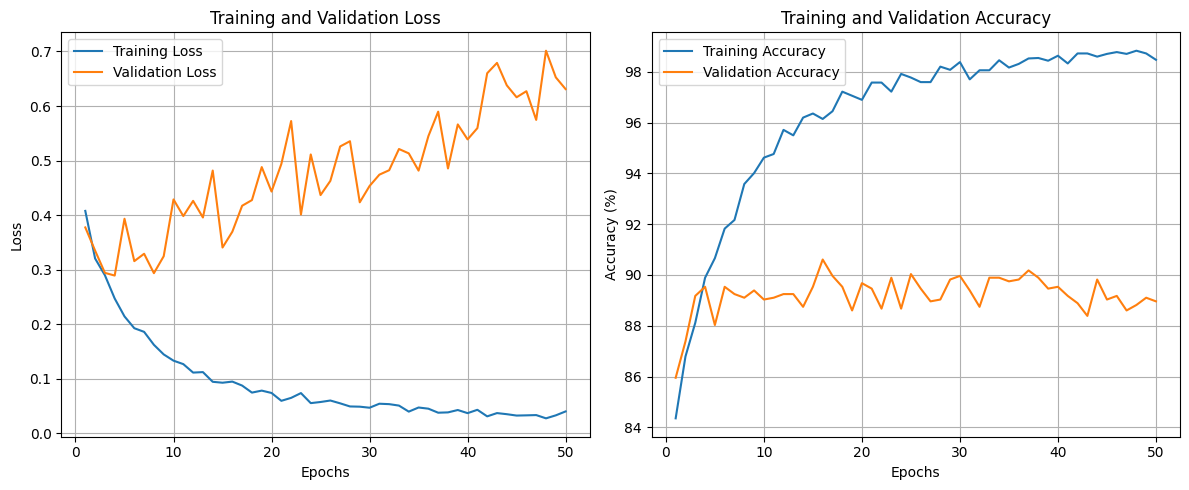

In [9]:
# Membuat daftar untuk menyimpan loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"Starting training on {DEVICE} for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")

    for inputs, labels in progress_bar_train:
        if inputs.nelement() == 0:
            continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        progress_bar_train.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_train if total_train > 0 else 0
    epoch_acc = (correct_train / total_train) * 100 if total_train > 0 else 0
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []

    progress_bar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch")
    with torch.no_grad():
        for inputs, labels in progress_bar_val:
            if inputs.nelement() == 0:
                continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            progress_bar_val.set_postfix(loss=loss.item())

    val_loss = running_val_loss / total_val if total_val > 0 else 0
    val_acc = (correct_val / total_val) * 100 if total_val > 0 else 0
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Training finished.")

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Starting Final Testing Phase...


Final Testing:   0%|          | 0/44 [00:00<?, ?batch/s]

Final Test Loss: 0.6310
Final Test Accuracy: 88.96%

Generating Confusion Matrix from Final Test Results...


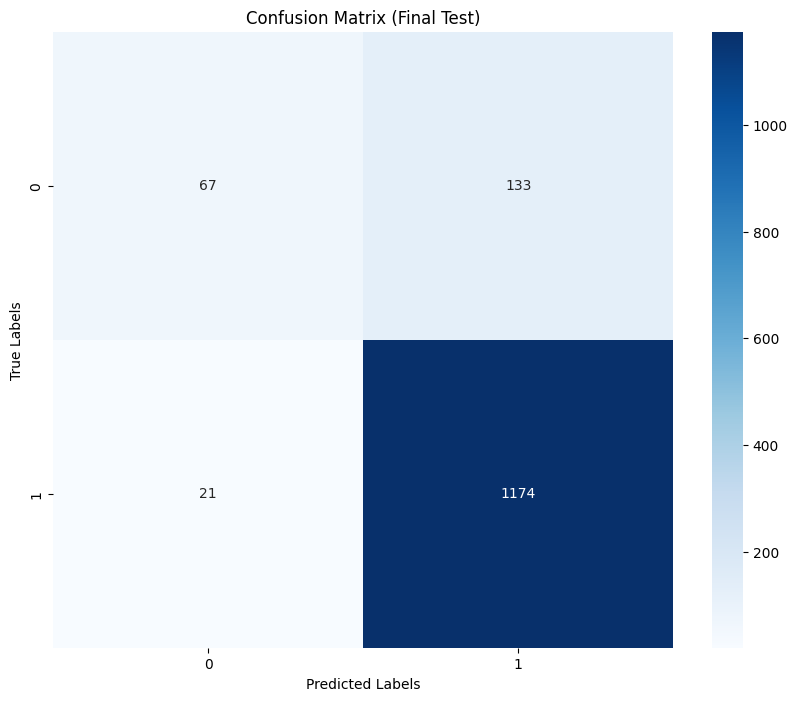

Model saved to efficientnet_b0_custom_pytorch.pth


In [10]:
print("\nStarting Final Testing Phase...")
model.eval()  

final_test_loss = 0.0
final_correct_test = 0
final_total_test = 0
final_all_preds = []
final_all_labels = []

with torch.no_grad(): 
    for inputs, labels in tqdm(test_loader, desc="Final Testing", unit="batch"): 
        if inputs.nelement() == 0: 
            continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels) 

        final_test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        final_total_test += labels.size(0)
        final_correct_test += (predicted == labels).sum().item()

        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_total_test > 0:
    avg_final_test_loss = final_test_loss / final_total_test
    final_test_accuracy = (final_correct_test / final_total_test) * 100
    print(f"Final Test Loss: {avg_final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")
else:
    print("No data was processed in the test loader during final testing.")

if final_total_test > 0:
    print("\nGenerating Confusion Matrix from Final Test Results...")
    cm = confusion_matrix(final_all_labels, final_all_preds) 
    plt.figure(figsize=(10, 8))
    class_names = [str(i) for i in range(NUM_CLASSES)] 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Final Test)')
    plt.show()
else:
    print("No data was processed in the test loader, cannot generate confusion matrix.")

torch.save(model.state_dict(), 'efficientnet_b0_custom_pytorch.pth')
print("Model saved to efficientnet_b0_custom_pytorch.pth")